In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torchinfo import summary
from contextlib import redirect_stdout
import os

from model.fcae import createLevel7Net20x20, createLevel7Net30x30, createLevel9Net, createLevel8Net, createLevel6Net

%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# load data
path_to_data = "./data/"

data_size = (30, 30)

X_file = np.load(f"{path_to_data}100000x{data_size[0]}x{data_size[1]}_unsolved.npy")
Y_file = np.load(f"{path_to_data}100000x{data_size[0]}x{data_size[1]}_solved.npy")

X_file = (X_file - X_file.min() ) / ( X_file.max() - X_file.min())
Y_file = Y_file

In [4]:
x_train, x_test, y_train, y_test = train_test_split(
    X_file, Y_file, test_size=0.2
)

# transform to tensor
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

x_test = torch.tensor(x_test, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device)

In [5]:
# create dataset
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

batchsize    = 64
train_loader = DataLoader(
    train_dataset, batch_size=batchsize, shuffle=True, drop_last=True
)
test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])

In [ ]:
def evaluate_found_path(answer: torch.Tensor, Y_test: torch.Tensor):
    start = find_gate(Y_test, 0.8, True, 3)
    end = find_gate(Y_test, 0.8, False, 3)

    if start is None or end is None:
        return False

    current = (start[0], start[1])
    visited = set()
    visited.add(current)

    max_moves = (
        answer.shape[0] * answer.shape[1]
    )  # Consider the grid size for max moves
    # max_moves = 17

    for i in range(max_moves):
        brightest_neighbour = find_brightest_neighbour(answer, current, visited, Y_test)
        if brightest_neighbour is None:
            return False
        current = (brightest_neighbour[0], brightest_neighbour[1])
        visited.add(current)
        if current == end:
            return True
    return False


def find_gate(answer: torch.Tensor, threshold: float, start: bool, gate_value: float = 1.0):
    # Definiere den Bereich, in dem nach dem Gate gesucht wird
    min_value = gate_value - threshold
    max_value = gate_value + threshold

    # Finde alle Kandidaten, die im Bereich [min_value, max_value] liegen
    gate_candidates = ((answer >= min_value) & (answer <= max_value)).nonzero(as_tuple=True)

    # Prüfe, ob Kandidaten existieren
    if len(gate_candidates[0]) == 0:
        return None  # Kein Gate gefunden

    # Wähle das erste oder letzte Gate aus
    if start:
        return gate_candidates[0][0].item(), gate_candidates[1][0].item()  # Erstes Gate
    else:
        return gate_candidates[0][-1].item(), gate_candidates[1][-1].item()  # Letztes Gate



def find_brightest_neighbour(
    answer: torch.Tensor,
    position: tuple[int, int],
    visited: set[tuple[int, int]],
    Y_test: torch.Tensor,
):
    rows, cols = answer.shape  # Get the actual number of rows and columns

    ind_up = (max(position[0] - 1, 0), position[1])
    ind_down = (min(position[0] + 1, rows - 1), position[1])
    ind_left = (position[0], max(position[1] - 1, 0))
    ind_right = (position[0], min(position[1] + 1, cols - 1))

    value_up = answer[ind_up[0]][ind_up[1]] if ind_up not in visited else -1
    value_down = answer[ind_down[0]][ind_down[1]] if ind_down not in visited else -1
    value_left = answer[ind_left[0]][ind_left[1]] if ind_left not in visited else -1
    value_right = answer[ind_right[0]][ind_right[1]] if ind_right not in visited else -1

    # Find the maximum value among the neighbours and return the corresponding index
    max_value = max(value_up, value_down, value_left, value_right)
    if max_value == -1:
        return None

    if max_value == value_up and Y_test[ind_up[0]][ind_up[1]] != 1.0:
        return ind_up
    elif max_value == value_down and Y_test[ind_down[0]][ind_down[1]] != 1.0:
        return ind_down
    elif max_value == value_left and Y_test[ind_left[0]][ind_left[1]] != 1.0:
        return ind_left
    elif max_value == value_right and Y_test[ind_right[0]][ind_right[1]] != 1.0:
        return ind_right

    return None


def evaluate_total_predictions_set(
    Y_hat: torch.Tensor, Y_test: torch.Tensor, verbose=True
):
    preds_: torch.Tensor = torch.zeros(Y_hat.shape[0], dtype=bool)

    # Dynamically determine the maze size from the data
    rows, cols = (
        Y_hat.shape[2],
        Y_hat.shape[3],
    )  # Assumes Y_hat has shape (batch_size, channels, rows, cols)

    wrong_predictions = []  # List to store images of wrong predictions

    for index in range(preds_.shape[0]):
        preds_[index] = evaluate_found_path(
            Y_hat[index].reshape(rows, cols), Y_test[index].reshape(rows, cols)
        )
        # Collect wrong predictions
        if not preds_[index]:
            wrong_predictions.append(Y_hat[index].reshape(rows, cols))

    total = preds_.shape[0]
    correct = preds_[preds_ == True].shape[0]
    correct_percentage = (correct / total) * 100

    if verbose:
        print("\n----------MODEL SUMMARY-----------")
        print("TOTAL SET SIZE: ", total)
        print("CORRECT GUESSES: ", correct)
        print("TOTALING TO ACCURACY%: ", correct_percentage)
        print("------------------------------------\n\n")

    if wrong_predictions:
        wrong_predictions_tensor = torch.stack(
            wrong_predictions
        )  # Stack wrong predictions into a tensor
    else:
        wrong_predictions_tensor = torch.empty(
            0
        )  # Return an empty tensor if no wrong predictions

    return correct_percentage, preds_, wrong_predictions_tensor


def display_mazes(
    mazes: torch.Tensor,
    n_rows: int = 1,
    n_cols: int = 5,
    figsize: tuple = (15, 3),
    max_mazes: int = 30,
):
    n_rows = mazes.shape[0] // n_cols

    num_mazes = min(len(mazes), n_rows * n_cols, max_mazes)

    n_rows = int(np.ceil(num_mazes / n_cols))
    figsize = (15, 3 * n_rows)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    for i in range(n_rows * n_cols):
        if i < num_mazes:
            maze = mazes[i, 0].detach().cpu().numpy()
            axes[i].imshow(maze, cmap="cividis", interpolation="none")
            axes[i].set_title(f"Maze {i+1}")
        else:
            axes[i].axis("off")

        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

    return fig

In [ ]:
def evaluateNet(model, test_loader, path="./archive/temp/"):
    os.makedirs(path, exist_ok=True)

    model.eval()
    model.to("cpu")
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to("cpu"), y.to("cpu")
            y_hat = model(X)
            all_preds.append(y_hat)
            all_labels.append(y)

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    correct_percentage, preds, wrong_preds = evaluate_total_predictions_set(all_preds.cpu(), all_labels.cpu())

    with open("./archive/temp/meta.txt", "w") as file:
        file.write(f"batch_size: {batchsize}\n")
        with redirect_stdout(file):
            print(summary(model, (batchsize, 1, data_size[0], data_size[1])))

    if wrong_preds.size(0) > 0:
        wrong_preds_unsqueezed = wrong_preds.unsqueeze(1)
        fig = display_mazes(wrong_preds_unsqueezed)
        fig.savefig(f"{path}wrong_predictions.png", bbox_inches="tight")
    else:
        print("No wrong predictions!")

    os.rename(path, f"./archive/{model.__class__.__name__}_{data_size[0]}x{data_size[1]}_{correct_percentage:.4f}")

In [8]:
channel_configuration = (32, 32, 64, 64, 128, 128, 256, 256, 512)
net, criterion, optimizer = createLevel8Net(channels=channel_configuration)
net.load_state_dict(
    torch.load(
        "./archive/temp/net.pt",
        weights_only=True,
    )
)

<All keys matched successfully>


----------MODEL SUMMARY-----------
TOTAL SET SIZE:  20000
CORRECT GUESSES:  17964
TOTALING TO ACCURACY%:  89.82
------------------------------------




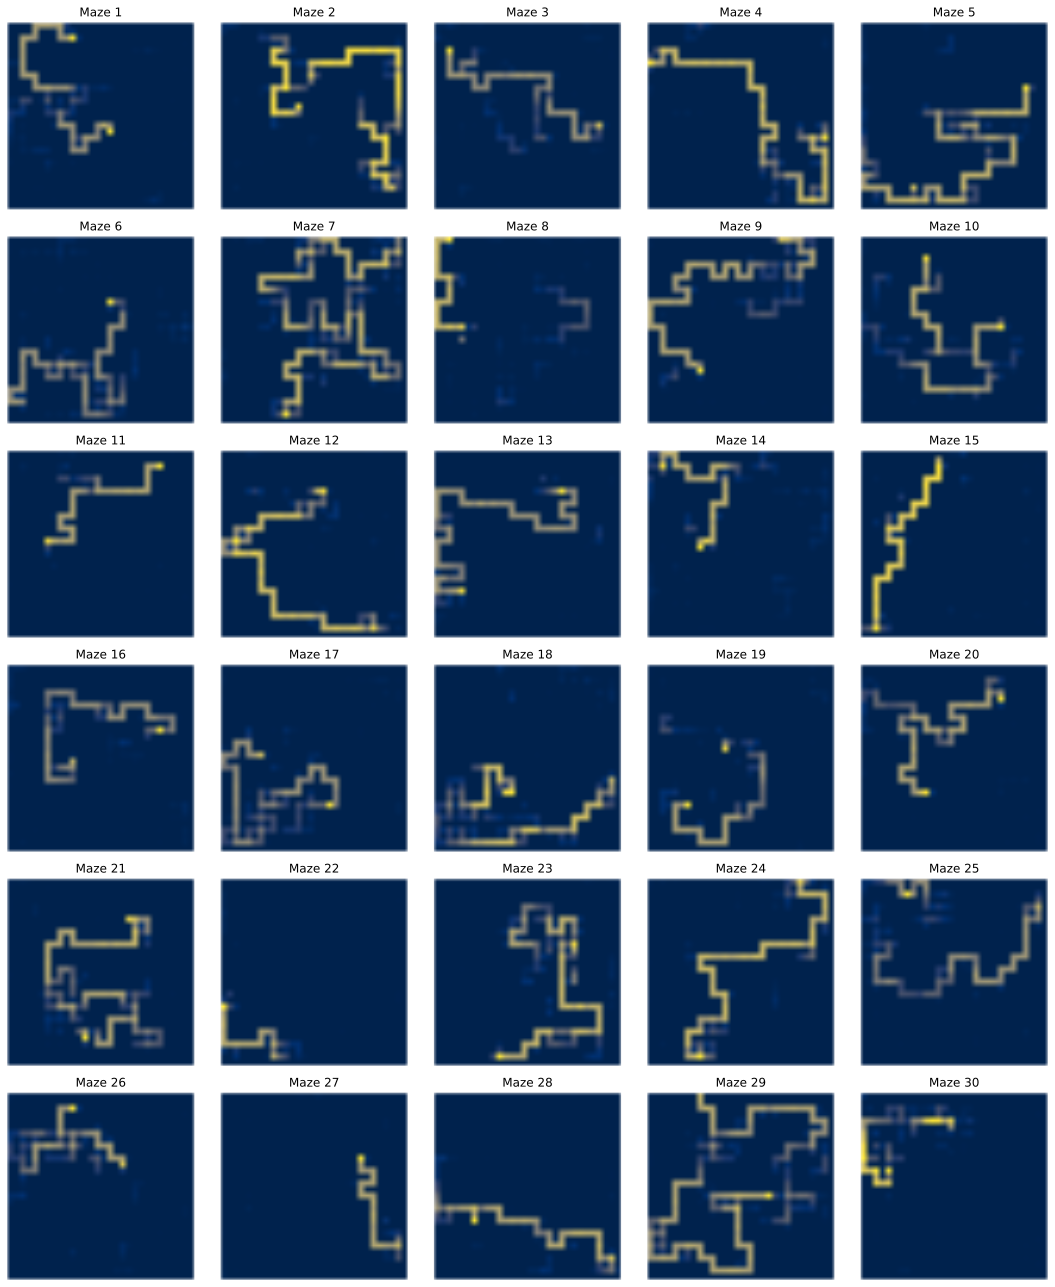

In [9]:
evaluateNet(net, test_loader)